In [1]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torchvision as tv
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader

In [2]:
## 工具函数
def make_regression_dataset(train_num=7000, test_num=3000, feat_num=500):
    """
    手动生成回归任务的数据集，要求：
    
    生成单个数据集，数据集的大小为10000且训练集大小为7000，测试集大小为3000。
    
    数据集的样本特征维度p为500
    """
    x = torch.randn((train_num, feat_num))
    y = (
        0.028
        + torch.sum(0.0056 * x)
        + torch.normal(mean=0, std=0.01, size=(train_num, 1))
    )
    train_x = x[:test_num]
    train_y = y[:test_num]
    test_x = x[test_num:]
    test_y = y[test_num:]
    train_data = TensorDataset(train_x, train_y)
    train_iter = DataLoader(train_data, batch_size=50, shuffle=True)
    test_data = TensorDataset(test_x, test_y)
    test_iter = DataLoader(test_data, batch_size=50, shuffle=False)
    return train_iter, test_iter


def make_classify_dataset(train_num=7000, test_num=3000, feat_num=200):
    """
    共生成两个数据集。
    
    两个数据集的大小均为10000且训练集大小为7000，测试集大小为3000。
    
    两个数据集的样本特征x的维度均为200，且分别服从均值互为相反数且方差相同的正态分布。
    
    两个数据集的样本标签分别为0和1。
    """
    x1 = torch.normal(size=(train_num + test_num, feat_num), mean=0.1, std=1)
    y1 = torch.zeros(x1.shape[0], dtype=torch.float32)
    x2 = torch.normal(size=(train_num + test_num, feat_num), mean=-0.1, std=1)
    y2 = torch.ones(x2.shape[0], dtype=torch.float32)

    train_x = torch.cat([x1[:train_num], x2[:train_num]], dim=0)
    train_y = torch.cat([y1[:train_num], y2[:train_num]], dim=0)
    train_data = TensorDataset(train_x, train_y)
    train_iter = DataLoader(train_data, batch_size=50, shuffle=True)

    test_x = torch.cat([x1[train_num:], x2[train_num:]], dim=0)
    test_y = torch.cat([y1[train_num:], y2[train_num:]], dim=0)
    test_data = TensorDataset(test_x, test_y)
    test_iter = DataLoader(test_data, batch_size=50, shuffle=False)
    # print(f"Class distribution: {torch.bincount(train_y.long())}")
    return train_iter, test_iter

def make_minist_dataset():
    """
    该数据集包含60,000个用于训练的图像样本和10,000个用于测试的图像样本。
    
    图像是固定大小(28x28像素)，其值为0到1。为每个图像都被平展并转换为784(28 * 28)个特征的一维numpy数组。
    """    
    train_data=tv.datasets.MNIST(root='./mnist_dataset',train=True,download=True,transform=tv.transforms.ToTensor())
    test_data=tv.datasets.MNIST(root='./mnist_dataset',train=False,download=True,transform=tv.transforms.ToTensor())
    train_iter=torch.utils.data.DataLoader(dataset=train_data,batch_size=32,shuffle=True,num_workers=0)
    test_iter=torch.utils.data.DataLoader(dataset=test_data,batch_size=32,shuffle=False,num_workers=0)
    return train_iter, test_iter


class Forward_Net(torch.nn.Module):
    """
    手动实现前馈神经网络解决回归问题
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(Forward_Net, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x
    
    
def calc_net_loss(net: Forward_Net, test_iter: DataLoader, loss_func: torch.nn.Module):
    net.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_iter:
            pred = net(x)
            test_loss += loss_func(pred, y.unsqueeze(1)).item()
    return test_loss / len(test_iter)
                    


任务一：torch.nn实现前馈神经网络解决回归问题

In [3]:
batch_size = 50
lr = 0.01
loss_func = torch.nn.MSELoss()
epoch_num = 50


train_iter, test_iter = make_regression_dataset()
net = Forward_Net(500, 256, 1)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss, test_loss = [], []
for epoch in range(epoch_num):
    train_loss_epoch = 0
    for x, y in train_iter:
        pred = net(x)
        loss = loss_func(pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_epoch += loss.item()
    train_loss.append(train_loss_epoch / len(train_iter))
    test_loss.append(calc_net_loss(net, test_iter, loss_func))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}")

plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.show()

/home/jcheng/.conda/envs/dl/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([50, 1, 1])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 6.537205708523591, Test Loss: 0.6216960716992617
Epoch 2, Train Loss: 0.45765123690168064, Test Loss: 0.5887830350548029
Epoch 3, Train Loss: 0.15732170157134534, Test Loss: 0.5324604541063309
Epoch 4, Train Loss: 0.056920412369072436, Test Loss: 0.5171986140310765
Epoch 5, Train Loss: 0.02132230930340787, Test Loss: 0.514920161291957
Epoch 6, Train Loss: 0.008183308799440661, Test Loss: 0.5148205514997244
Epoch 7, Train Loss: 0.0031041902606375516, Test Loss: 0.5137879580259324
Epoch 8, Train Loss: 0.0013024060715300342, Test Loss: 0.5117442183196544
Epoch 9, Train Loss: 0.0005545620074068817, Test Loss: 0.5116699121892452
Epoch 10, Train Loss: 0.00028262131672818214, Test Loss: 0.5120420850813389
Epoch 11, Train Loss: 0.00017278016166528688, Test Loss: 0.5116714902222157
Epoch 12, Train Loss: 0.0001294178066018503, Test Loss: 0.5119710147380829
Epoch 13, Train Loss: 0.00011110046834801323, Test Loss: 0.5118003390729428
Epoch 14, Train Loss: 0.00010440099795232527

KeyboardInterrupt: 

实验结果分析：通过模型训练，随着epoch增加，训练集的loss逐渐降低，同时测试集的loss也逐渐降低，表明模型在回归任务中学习的参数逐渐趋于优，并且模型的优化速度较快。

任务二：torch.nn实现前馈神经网络解决二分类问题

Epoch 1, Train Loss: 0.6916702021445547, Test Loss: 0.682104782263438, Test Acc: 0.5596666666666666
Epoch 2, Train Loss: 0.6737909116915294, Test Loss: 0.6650547554095586, Test Acc: 0.6316666666666667
Epoch 3, Train Loss: 0.6570558269109045, Test Loss: 0.6485840385158856, Test Acc: 0.6883333333333334
Epoch 4, Train Loss: 0.6404833035809653, Test Loss: 0.6319481655955315, Test Acc: 0.7355
Epoch 5, Train Loss: 0.6235139487045152, Test Loss: 0.6147546693682671, Test Acc: 0.77
Epoch 6, Train Loss: 0.6058309544410024, Test Loss: 0.596769550939401, Test Acc: 0.7968333333333333
Epoch 7, Train Loss: 0.5872848681041173, Test Loss: 0.577903795739015, Test Acc: 0.82
Epoch 8, Train Loss: 0.5678142196365765, Test Loss: 0.5581513966123263, Test Acc: 0.839
Epoch 9, Train Loss: 0.5475160947867802, Test Loss: 0.5376650400459766, Test Acc: 0.8516666666666667
Epoch 10, Train Loss: 0.5265740936355932, Test Loss: 0.5166478301088016, Test Acc: 0.865
Epoch 11, Train Loss: 0.5052394293248653, Test Loss: 0.495

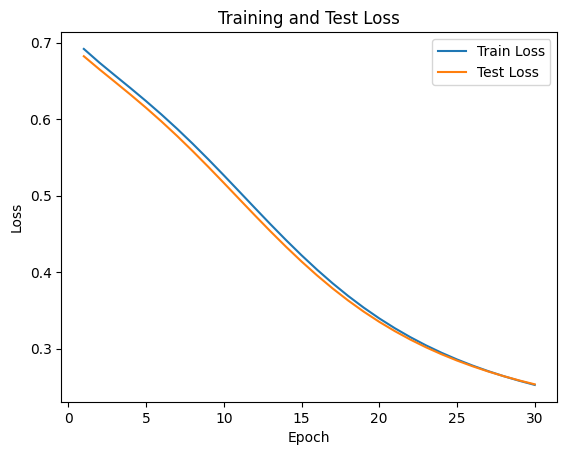

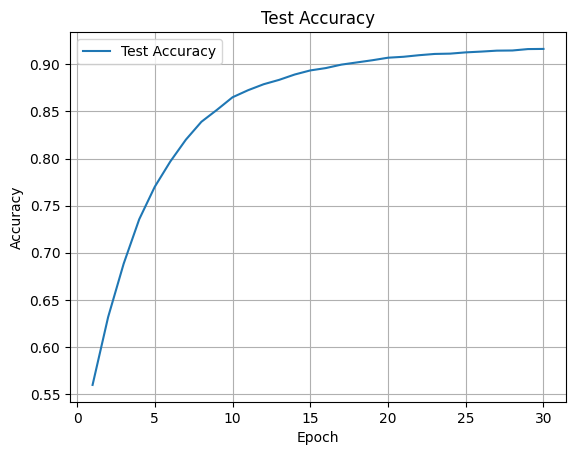

In [ ]:
def calc_net_acc(net: Forward_Net, test_iter: DataLoader):
    net.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in test_iter:
            pred = net(x)
            predicted_labels = (torch.sigmoid(pred) > 0.5).squeeze(1).long()
            correct_predictions += (predicted_labels == y.long()).sum().item()
            total_samples += y.size(0)
    return correct_predictions / total_samples


batch_size = 50
lr = 0.001
loss_func = torch.nn.BCEWithLogitsLoss()
epoch_num = 30

train_iter, test_iter = make_classify_dataset()
net = Forward_Net(200, 100, 1)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss, test_loss, test_acc = [], [], []
for epoch in range(epoch_num):
    train_loss_epoch = 0
    for x, y in train_iter:
        pred = net(x)
        loss = loss_func(pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_epoch += loss.item()
    train_loss.append(train_loss_epoch / len(train_iter))
    test_loss.append(calc_net_loss(net, test_iter, loss_func))
    test_acc.append(calc_net_acc(net, test_iter))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}, Test Acc: {test_acc[-1]}")

# 损失曲线
plt.plot(range(1, epoch_num+1), train_loss, label='Train Loss')
plt.plot(range(1, epoch_num+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()
# 测试准确率
plt.plot(range(1, epoch_num+1), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

实验结果分析：通过模型训练，随着epoch增加，训练集的loss逐渐降低，同时测试集的loss也逐渐降低，准确率逐渐增加，表明模型在二分类任务中学习的参数逐渐趋于优，并且模型的优化速度较快。

任务三：torch.nn实现前馈神经网络解决多分类问题

In [ ]:
from torch import Tensor

def calc_net_loss(net: Forward_Net, test_iter: DataLoader, loss_func: torch.nn.Module):
    net.eval()
    loss_sum = 0
    with torch.no_grad():
        for x, y in test_iter:
            x = x.view(-1, 28*28)
            pred:Tensor = net(x)
            loss = loss_func(pred, y)
            loss_sum += loss.item()
    return loss_sum / len(test_iter)

def calc_net_acc(net: Forward_Net, test_iter: DataLoader):
    net.eval()
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in test_iter:
            x = x.view(-1, 28*28)
            pred:Tensor = net(x)
            predicted_labels = pred.argmax(dim=1).long()
            correct_predictions += (predicted_labels == y.long()).sum().item()
            total_samples += y.size(0)
    return correct_predictions / total_samples


batch_size = 32
lr = 0.01
loss_func = torch.nn.CrossEntropyLoss()
epoch_num = 30

train_iter, test_iter = make_minist_dataset()
net = Forward_Net(28*28, 256, 10)
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

train_loss, test_loss, test_acc = [], [], []
for epoch in range(epoch_num):
    train_loss_epoch = 0
    for x, y in train_iter:
        x = x.view(-1, 28*28)
        pred = net(x)
        # print(x.shape, x.view(-1, 28*28).shape, pred.shape, y.shape)
        loss = loss_func(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_epoch += loss.item()
    train_loss.append(train_loss_epoch / len(train_iter))
    test_loss.append(calc_net_loss(net, test_iter, loss_func))
    test_acc.append(calc_net_acc(net, test_iter))
    print(f"Epoch {epoch+1}, Train Loss: {train_loss[-1]}, Test Loss: {test_loss[-1]}, Test Acc: {test_acc[-1]}")

# 损失曲线
plt.plot(range(1, epoch_num+1), train_loss, label='Train Loss')
plt.plot(range(1, epoch_num+1), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()
# 测试准确率
plt.plot(range(1, epoch_num+1), test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1, Train Loss: 0.8490413742780686, Test Loss: 0.40188365330854164, Test Acc: 0.8931
Epoch 2, Train Loss: 0.37348967080116274, Test Loss: 0.3219861364462219, Test Acc: 0.909
Epoch 3, Train Loss: 0.3200371686041355, Test Loss: 0.2879627874841134, Test Acc: 0.918
Epoch 4, Train Loss: 0.28916863313913344, Test Loss: 0.26607106429355115, Test Acc: 0.9248
Epoch 5, Train Loss: 0.2657361568013827, Test Loss: 0.24547539119974685, Test Acc: 0.9316
Epoch 6, Train Loss: 0.24541842310925324, Test Loss: 0.23027106496198965, Test Acc: 0.9359
Epoch 7, Train Loss: 0.22814596533377965, Test Loss: 0.21455293508788076, Test Acc: 0.9385
Epoch 8, Train Loss: 0.21271726327836513, Test Loss: 0.20088110067479956, Test Acc: 0.9428
Epoch 9, Train Loss: 0.19902788452605408, Test Loss: 0.1890718313395239, Test Acc: 0.9455
Epoch 10, Train Loss: 0.18712759707669416, Test Loss: 0.18149318279454502, Test Acc: 0.9491
Epoch 11, Train Loss: 0.17634075968563556, Test Loss: 0.17103878964860433, Test Acc: 0.9513
Epoch

KeyboardInterrupt: 

实验结果分析：随着epoch增加，训练集和测试集上的loss逐渐降低，准确率逐渐提高，表明模型在解决多分类任务的训练过程中不断优化，并拥有了较好的泛化能力。